Amostra dos Resultados:


,simulation_id,anova_p_value,anova_detects_effect,rf_accuracy
0,0,0.001212,True,1.0
1,1,0.000830,True,1.0
2,2,0.000131,True,1.0
3,3,0.005477,True,1.0
4,4,0.008328,True,1.0



Resumo Estatístico:


,simulation_id,anova_p_value,rf_accuracy
count,1000.000000,1.000000e+03,1000.000000
mean,499.500000,3.802737e-02,0.998956
std,288.819436,1.048667e-01,0.003244
min,0.000000,6.160269e-10,0.988889
25%,249.750000,1.307259e-04,1.000000
50%,499.500000,1.889821e-03,1.000000
75%,749.250000,1.916267e-02,1.000000
max,999.000000,9.424259e-01,1.000000


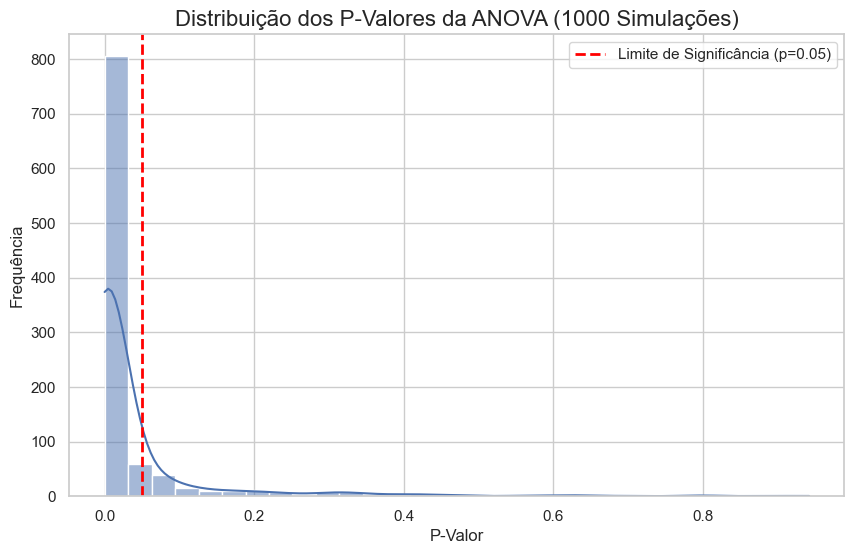

In [1]:
# Importando as bibliotecas de análise
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")

# Carregando os resultados da nossa simulação
df_results = pd.read_csv('mvp_results.csv')

# Exibindo as primeiras linhas e um resumo estatístico
print("Amostra dos Resultados:")
display(df_results.head())

print("\nResumo Estatístico:")
display(df_results.describe())

# --- Visualização Chave ---
# Vamos ver a distribuição dos p-valores da ANOVA
plt.figure(figsize=(10, 6))
sns.histplot(data=df_results, x='anova_p_value', bins=30, kde=True)

# Adicionamos uma linha vertical no nosso nível de significância (0.05)
plt.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='Limite de Significância (p=0.05)')

plt.title('Distribuição dos P-Valores da ANOVA (1000 Simulações)', fontsize=16)
plt.xlabel('P-Valor', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend()
plt.show()